<a href="https://colab.research.google.com/github/akxhhay/Academia_Filler/blob/main/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import cv2
import PIL

from tensorflow.keras import Model
     

In [13]:
#importing the vgg model with pretrained weights
vgg = tf.keras.applications.VGG19(include_top=True,weights='imagenet')
for layers in vgg.layers:
  print(f"{layers.name} --> {layers.output_shape}")

input_4 --> [(None, 224, 224, 3)]
block1_conv1 --> (None, 224, 224, 64)
block1_conv2 --> (None, 224, 224, 64)
block1_pool --> (None, 112, 112, 64)
block2_conv1 --> (None, 112, 112, 128)
block2_conv2 --> (None, 112, 112, 128)
block2_pool --> (None, 56, 56, 128)
block3_conv1 --> (None, 56, 56, 256)
block3_conv2 --> (None, 56, 56, 256)
block3_conv3 --> (None, 56, 56, 256)
block3_conv4 --> (None, 56, 56, 256)
block3_pool --> (None, 28, 28, 256)
block4_conv1 --> (None, 28, 28, 512)
block4_conv2 --> (None, 28, 28, 512)
block4_conv3 --> (None, 28, 28, 512)
block4_conv4 --> (None, 28, 28, 512)
block4_pool --> (None, 14, 14, 512)
block5_conv1 --> (None, 14, 14, 512)
block5_conv2 --> (None, 14, 14, 512)
block5_conv3 --> (None, 14, 14, 512)
block5_conv4 --> (None, 14, 14, 512)
block5_pool --> (None, 7, 7, 512)
flatten --> (None, 25088)
fc1 --> (None, 4096)
fc2 --> (None, 4096)
predictions --> (None, 1000)


In [14]:
#importing the vgg model with pretrained weights
vgg = tf.keras.applications.VGG19(include_top=True,weights='imagenet')
for layers in vgg.layers:
  print(f"{layers.name} --> {layers.output_shape}")

input_5 --> [(None, 224, 224, 3)]
block1_conv1 --> (None, 224, 224, 64)
block1_conv2 --> (None, 224, 224, 64)
block1_pool --> (None, 112, 112, 64)
block2_conv1 --> (None, 112, 112, 128)
block2_conv2 --> (None, 112, 112, 128)
block2_pool --> (None, 56, 56, 128)
block3_conv1 --> (None, 56, 56, 256)
block3_conv2 --> (None, 56, 56, 256)
block3_conv3 --> (None, 56, 56, 256)
block3_conv4 --> (None, 56, 56, 256)
block3_pool --> (None, 28, 28, 256)
block4_conv1 --> (None, 28, 28, 512)
block4_conv2 --> (None, 28, 28, 512)
block4_conv3 --> (None, 28, 28, 512)
block4_conv4 --> (None, 28, 28, 512)
block4_pool --> (None, 14, 14, 512)
block5_conv1 --> (None, 14, 14, 512)
block5_conv2 --> (None, 14, 14, 512)
block5_conv3 --> (None, 14, 14, 512)
block5_conv4 --> (None, 14, 14, 512)
block5_pool --> (None, 7, 7, 512)
flatten --> (None, 25088)
fc1 --> (None, 4096)
fc2 --> (None, 4096)
predictions --> (None, 1000)


In [15]:
def gm_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd',input_tensor,input_tensor)
  gm_matrix = tf.expand_dims(result,axis=0)
  ip_shape = tf.shape(input_tensor)
  i_j = tf.cast(ip_shape[1]*ip_shape[2], tf.float32)
  return gm_matrix/i_j

In [16]:

def load_vgg():
  vgg = tf.keras.applications.VGG19(include_top=True, weights="imagenet")
  vgg.trainable = False
  content_layers = ['block4_conv2']
  style_layers= ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
  content_op = vgg.get_layer(content_layers[0]).output
  style_op = [vgg.get_layer(style_layer).output for style_layer in style_layers]
  gm_style_op = [gm_matrix(output_) for output_ in style_op]

  model = Model([vgg.input],[content_op, gm_style_op])
  return model


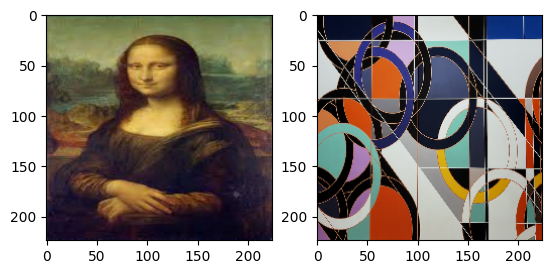

In [17]:
%matplotlib inline
content_img = cv2.resize(cv2.imread('/content/zzz.jpeg'),(224,224))
content_img = tf.image.convert_image_dtype(content_img,tf.float32)
style_img = cv2.resize(cv2.imread('/content/ma.jpeg'),(224,224))
style_img = tf.image.convert_image_dtype(style_img,tf.float32)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(np.array(content_img), cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(np.array(style_img), cv2.COLOR_BGR2RGB))
plt.show()

In [19]:

def loss_object(style_ops, content_ops, style_target, content_target):
  style_weight = 1e-4
  content_weight = 10
  content_loss = tf.reduce_mean((content_ops - content_target)**2)
  style_loss = tf.add_n([tf.reduce_mean((output_ - target_)**2) for output_, target_ in zip(style_ops, style_target)])
  total_loss = content_weight*content_loss + style_weight*style_loss
  return total_loss


In [20]:
vgg_model = load_vgg()
content_target = vgg_model(np.array([content_img*255]))[0]
style_target = vgg_model(np.array([style_img*255]))[1]

In [21]:
opt = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

In [22]:

def train_step(image,epoch):
  with tf.GradientTape() as tape:
    output = vgg_model(image*255)
    loss = loss_object(output[1],output[0], style_target, content_target)
  gradient = tape.gradient(loss, image)
  opt.apply_gradients([(gradient, image)])
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

  if epoch % 100 == 0:
    tf.print(f"Loss = {loss}")

In [23]:

Epochs = 700
image = tf.image.convert_image_dtype(content_img, tf.float32)
image = tf.Variable([image])
for i in range(Epochs):
  train_step(image, i)

Loss = 183125664.0
Loss = 18905280.0
Loss = 14442766.0
Loss = 12508215.0
Loss = 11461063.0
Loss = 10822986.0
Loss = 10403870.0


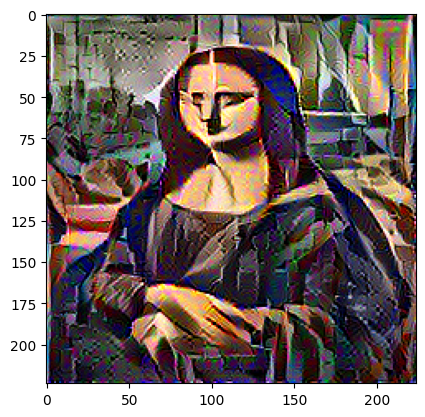

In [24]:
tensor = image*255
tensor = np.array(tensor, dtype = np.uint8)
if np.ndim(tensor) > 3:
  assert tensor.shape[0] == 1
  tensor = tensor[0]
tensor = PIL.Image.fromarray(tensor)
plt.imshow(cv2.cvtColor(np.array(tensor), cv2.COLOR_BGR2RGB))
plt.show()
     